In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
import numpy as np
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [268]:
df = pd.read_csv('delivery.txt',delimiter=",").fillna(0)

In [252]:
df['DELIVERY_DATE']=pd.to_datetime(df['DELIVERY_DATE'])

In [269]:
df=pd.read_csv('output.csv')
df['DELIVERY_DATE']=pd.to_datetime(df['DELIVERY_DATE'])

In [270]:
df3=pd.get_dummies(df2["best"],prefix='best',drop_first=True)

In [271]:
df=pd.concat([df,df3], axis=1, sort=False)

In [274]:
df['DELIVERY_DATE']=pd.to_datetime(df['DELIVERY_DATE'])

In [283]:
df.drop('best',axis=1,inplace=True)

In [284]:
print(df.dtypes)

DELIVERY_DATE       datetime64[ns]
DELIVERED_VOLUME             int64
Facility_A                   int64
Facility_B                   int64
Facility_C                   int64
Facility_D                   int64
Facility_E                   int64
Facility_F                   int64
Facility_G                   int64
Facility_H                   int64
Facility_I                   int64
Facility_J                   int64
Facility_K                   int64
WEEKDAY                      int64
WEEKEND                       bool
date                        object
hour                         int64
dayofweek                    int64
quarter                      int64
month                        int64
year                         int64
dayofyear                    int64
dayofmonth                   int64
weekofyear                   int64
weekend                       bool
best_Facility_C              uint8
best_Facility_D              uint8
best_Facility_E              uint8
best_Facility_G     

In [285]:
df.head()

,DELIVERY_DATE,DELIVERED_VOLUME,Facility_A,Facility_B,Facility_C,Facility_D,Facility_E,Facility_F,Facility_G,Facility_H,...,dayofyear,dayofmonth,weekofyear,weekend,best_Facility_C,best_Facility_D,best_Facility_E,best_Facility_G,best_Facility_H,ma
0,2019-03-13,0,0,0,0,1,0,0,0,0,...,72,13,11,True,0,1,0,0,0,0.0
1,2019-03-14,0,0,0,0,8,0,0,0,0,...,73,14,11,True,0,1,0,0,0,0.0
2,2019-03-15,0,0,1,0,6,0,0,0,0,...,74,15,11,True,0,1,0,0,0,0.0
3,2019-03-18,0,0,0,0,55,3,0,45,86,...,77,18,12,True,0,0,0,0,1,0.0
4,2019-03-19,0,13,0,0,3,9,80,243,80,...,78,19,12,True,0,0,0,1,0,0.0


In [158]:
df['WEEKEND']=np.where(df['WEEKDAY']<5, True, False)

In [159]:
df.head()

,DELIVERY_DATE,DELIVERED_VOLUME,Facility_A,Facility_B,Facility_C,Facility_D,Facility_E,Facility_F,Facility_G,Facility_H,...,year,dayofyear,dayofmonth,weekofyear,weekend,best_Facility_C,best_Facility_D,best_Facility_E,best_Facility_G,best_Facility_H
0,2019-03-13,0,0,0,0,1,0,0,0,0,...,2019,72,13,11,True,0,1,0,0,0
1,2019-03-14,0,0,0,0,8,0,0,0,0,...,2019,73,14,11,True,0,1,0,0,0
2,2019-03-15,0,0,1,0,6,0,0,0,0,...,2019,74,15,11,True,0,1,0,0,0
3,2019-03-18,0,0,0,0,55,3,0,45,86,...,2019,77,18,12,True,0,0,0,0,1
4,2019-03-19,0,13,0,0,3,9,80,243,80,...,2019,78,19,12,True,0,0,0,1,0


In [131]:
df[['DELIVERY_DATE','WEEKDAY','WEEKEND']].head()

,DELIVERY_DATE,WEEKDAY,WEEKEND
0,2019-03-13,2,True
1,2019-03-14,3,True
2,2019-03-15,4,True
3,2019-03-18,0,True
4,2019-03-19,1,True


##

In [288]:
df.set_index('DELIVERY_DATE',inplace = True)

In [289]:
split_date = '2019-05-01'
df_train =df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [259]:
df.columns

Index(['DELIVERED_VOLUME', 'Facility_A', 'Facility_B', 'Facility_C',
       'Facility_D', 'Facility_E', 'Facility_F', 'Facility_G', 'Facility_H',
       'Facility_I', 'Facility_J', 'Facility_K', 'WEEKDAY', 'WEEKEND', 'date',
       'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'weekend', 'best', 'ma'],
      dtype='object')

In [261]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['weekend'] = df['WEEKEND']

    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekend','best_Facility_C',
       'best_Facility_D', 'best_Facility_E', 'best_Facility_G',
       'best_Facility_H','ma']]
    if label:
        y = df[label]
        return X, y
    return X

In [290]:
X_train, y_train = create_features(df_train, label='DELIVERED_VOLUME')
X_test, y_test = create_features(df_test, label='DELIVERED_VOLUME')

In [185]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [190]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [291]:
reg = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600,
                    silent=True, nthread=1)

In [292]:
Y = y_train.values
X = X_train.reset_index().drop('DELIVERY_DATE',axis=1)

In [211]:
X.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekend,best_Facility_C,best_Facility_D,best_Facility_E,best_Facility_G,best_Facility_H
0,0,2,1,3,2019,72,13,11,True,0,1,0,0,0
1,0,3,1,3,2019,73,14,11,True,0,1,0,0,0
2,0,4,1,3,2019,74,15,11,True,0,1,0,0,0
3,0,0,1,3,2019,77,18,12,True,0,0,0,0,1
4,0,1,1,3,2019,78,19,12,True,0,0,0,1,0


In [231]:
folds = 2
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(reg, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

# Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X, Y)
# timer(start_time) # timing ends here for "start_time" variable

In [293]:
reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=20,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

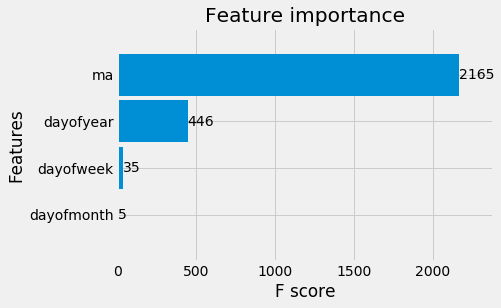

In [294]:
_ = plot_importance(reg, height=0.9)

In [225]:
df_test['MW_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

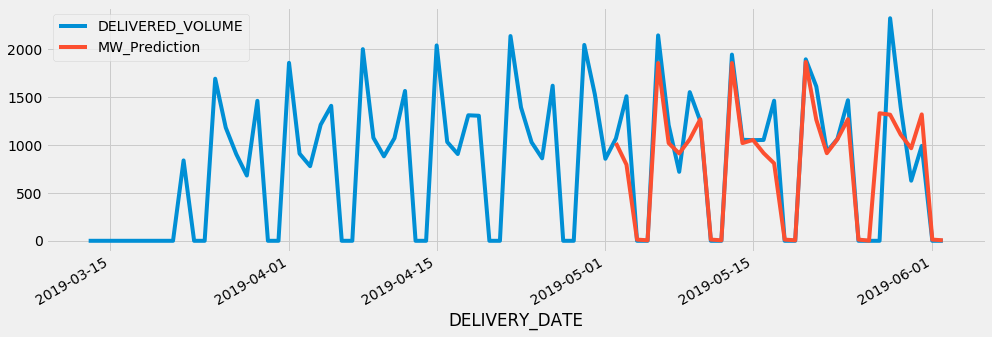

In [226]:
_ = df_all[['DELIVERED_VOLUME','MW_Prediction']].plot(figsize=(15, 5))

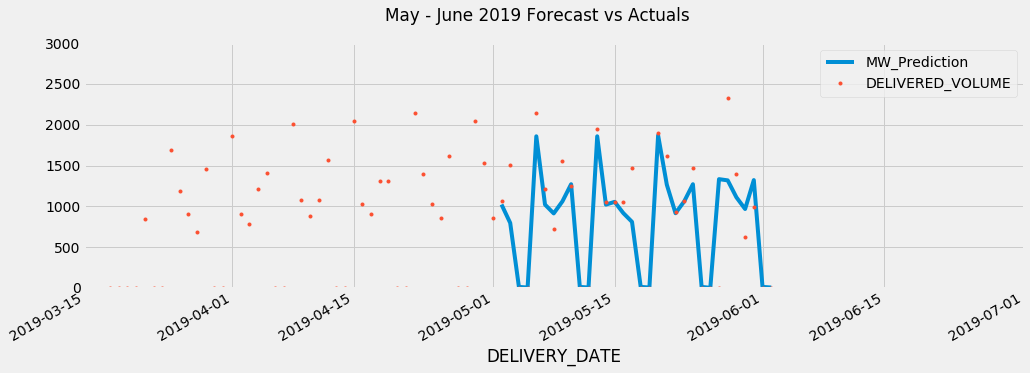

In [227]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','DELIVERED_VOLUME']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='03-15-2019', upper='07-01-2019')
ax.set_ylim(0, 3000)
plot = plt.suptitle('May - June 2019 Forecast vs Actuals')
# %matplot plt

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [228]:
mean_squared_error(y_true=df_test['DELIVERED_VOLUME'],
                   y_pred=df_test['MW_Prediction'])

144696.60332904407

In [176]:
mean_absolute_error(y_true=df_test['DELIVERED_VOLUME'],
                   y_pred=df_test['MW_Prediction'])

214.82483138144016

In [177]:
df_test['error'] = df_test['DELIVERED_VOLUME'] - df_test['MW_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['DELIVERED_VOLUME','MW_Prediction','error','abs_error']]

In [180]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [182]:
mean_absolute_percentage_error(y_true=df_test['DELIVERED_VOLUME'],
                   y_pred=df_test['MW_Prediction'])

/Users/xumingshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


inf

In [178]:
error_by_day.sort_values('error', ascending=True).head(10)

DELIVERED_VOLUME  MW_Prediction        error  \
year month dayofmonth                                                 
2019 5     27                         0    1339.953003 -1339.953003   
           31                       992    1324.926147  -332.926147   
           30                       628     946.419250  -318.419250   
           8                        721     919.301453  -198.301453   
           10                      1251    1297.808472   -46.808472   
           11                         0      11.185303   -11.185303   
           4                          0      11.185303   -11.185303   
           25                         0      11.185303   -11.185303   
           18                         0      11.185303   -11.185303   
           5                          0       4.262821    -4.262821   

                         abs_error  
year month dayofmonth               
2019 5     27          1339.953003  
           31           332.926147  
           30           318.419250  
           8            198.301453  
           10            46.808472  
           11            11.185303  
           4             11.185303  
           25            11.185303  
           18            11.185303  
           5              4.262821

In [179]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

DELIVERED_VOLUME  MW_Prediction        error  \
year month dayofmonth                                                 
2019 5     27                         0    1339.953003 -1339.953003   
           28                      2326    1304.725830  1021.274170   
           3                       1511     794.216797   716.783203   
           17                      1464     812.865967   651.134033   
           9                       1554    1051.369507   502.630493   
           21                      1613    1277.608154   335.391846   
           31                       992    1324.926147  -332.926147   
           29                      1398    1078.487183   319.512817   
           30                       628     946.419250  -318.419250   
           6                       2147    1857.878784   289.121216   

                         abs_error  
year month dayofmonth               
2019 5     27          1339.953003  
           28          1021.274170  
           3            716.783203  
           17           651.134033  
           9            502.630493  
           21           335.391846  
           31           332.926147  
           29           319.512817  
           30           318.419250  
           6            289.121216

In [119]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

DELIVERED_VOLUME  MW_Prediction      error  abs_error
year month dayofmonth                                                       
2019 5     19                       0.0      -0.926652   0.926652   0.926652
           18                       0.0       4.065208  -4.065208   4.065208
           25                       0.0      -7.101656   7.101656   7.101656
           5                        0.0      -9.025790   9.025790   9.025790
           11                       0.0     -14.165874  14.165874  14.165874
     6     2                        0.0     -17.478140  17.478140  17.478140
           1                        0.0     -18.423166  18.423166  18.423166
     5     7                     1210.0    1245.016602 -35.016602  35.016602
           26                       0.0      36.914127 -36.914127  36.914127
           2                     1070.0    1022.731628  47.268372  47.268372

In [229]:
df.to_csv('output2.csv')

In [243]:
df2=pd.read_csv('output.csv')
df3=pd.get_dummies(df2["best"],prefix='best',drop_first=True)
df_concat=pd.concat([df2,df3], axis=1, sort=False)
df_concat.drop('best',axis=1,inplace=True)


In [277]:
df['ma']=df['DELIVERED_VOLUME'].rolling(window=1).mean()

In [246]:
df

,DELIVERED_VOLUME,Facility_A,Facility_B,Facility_C,Facility_D,Facility_E,Facility_F,Facility_G,Facility_H,Facility_I,...,dayofyear,dayofmonth,weekofyear,weekend,best_Facility_C,best_Facility_D,best_Facility_E,best_Facility_G,best_Facility_H,ma
DELIVERY_DATE,,,,,,,,,,,,,,,,,,,,,
2019-03-13,0,0,0,0,1,0,0,0,0,0,...,72,13,11,True,0,1,0,0,0,0.0
2019-03-14,0,0,0,0,8,0,0,0,0,0,...,73,14,11,True,0,1,0,0,0,0.0
2019-03-15,0,0,1,0,6,0,0,0,0,0,...,74,15,11,True,0,1,0,0,0,0.0
2019-03-18,0,0,0,0,55,3,0,45,86,0,...,77,18,12,True,0,0,0,0,1,0.0
2019-03-19,0,13,0,0,3,9,80,243,80,0,...,78,19,12,True,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-29,1398,284,36,206,46,328,79,414,69,14,...,149,29,22,True,0,0,0,1,0,1398.0
2019-05-30,628,264,21,179,9,382,71,311,104,9,...,150,30,22,True,0,0,1,0,0,628.0
2019-05-31,992,208,52,163,48,312,79,401,109,8,...,151,31,22,True,0,0,0,1,0,992.0
